# Distributional impact within groups



Modeled after [Anderson Frailey's notebook](http://nbviewer.jupyter.org/github/andersonfrailey/Notebook-Uploads/blob/master/Visualizing%20the%20TCJA.ipynb) using Bokeh, which was in turn modeled after [Jonathan Schwabish's piece for Urban](https://www.urban.org/urban-wire/how-we-can-better-visualize-analysis-tax-reform-legislation).

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'1.1.0'

### 2017 law

In [3]:
BASE_URL = ('https://raw.githubusercontent.com/' +
            'open-source-economics/Tax-Calculator/master/taxcalc/reforms/')
y2017_name = '2017_law.json'
y2017_reform = tc.Calculator.read_json_param_objects(BASE_URL + y2017_name, None)

### Settings

In [4]:
sns.set_style('white')
DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [5]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [6]:
# Number of decimals when printing pandas DataFrames.
pd.set_option('precision', 2)

## Generate data

In [7]:
recs = tc.Records.cps_constructor()
pol = tc.Policy()
calc_tcja = tc.Calculator(records=recs, policy=pol, verbose=False)
calc_tcja.advance_to_year(2018)
calc_tcja.calc_all()

pol.implement_reform(y2017_reform['policy'])
calc_base = tc.Calculator(records=recs, policy=pol, verbose=False)
calc_base.advance_to_year(2018)
calc_base.calc_all()

In [8]:
base = calc_base.dataframe(['RECID', 'expanded_income', 'aftertax_income', 
                            's006', 'XTOT'])
base.rename(columns={'aftertax_income': 'afti_base',
                     'expanded_income': 'expi_base'}, inplace=True)
tcja = calc_tcja.dataframe(['RECID', 'aftertax_income'])
tcja.rename(columns={'aftertax_income': 'afti_tcja'}, inplace=True)

In [9]:
tu = pd.merge(base, tcja, on='RECID').drop(columns='RECID')

## Preprocess

In [10]:
tu['XTOT_s006'] = tch.weight(tu, 'XTOT')

Add income bins. By setting 0 as the minimum bin, tax units with negative income will be assigned a null bucket, and be dropped from the charts.

In [11]:
tu['afti_base_bin'] = (
    pd.cut(tu.afti_base.astype('int'),
           pd.Series([0, 10, 20, 30, 40, 50, 75, 100, 200, 500, 1000, np.inf])
           * 1000,
           labels=['Less than \$10K', '\$10K to \$20K', '\$20K to \$30K', 
                   '\$30K to \$40K', '\$40K to \$50K', '\$50K to \$75K', 
                   '\$75K to \$100K', '\$100K to \$200K', '\$200K to \$500K', 
                   '\$500K to \$1M', '\$1M or more']))

In [12]:
tu['expi_base_bin'] = (
    pd.cut(tu.expi_base.astype('int'),
           pd.Series([0, 10, 20, 30, 40, 50, 75, 100, 200, 500, 1000, np.inf])
           * 1000,
           labels=['Less than \$10K', '\$10K to \$20K', '\$20K to \$30K', 
                   '\$30K to \$40K', '\$40K to \$50K', '\$50K to \$75K', 
                   '\$75K to \$100K', '\$100K to \$200K', '\$200K to \$500K', 
                   '\$500K to \$1M', '\$1M or more']))

In [13]:
tu['tax_chg_bin'] = pd.cut(
    tu.afti_base - tu.afti_tcja, 
    [-np.inf, -500, -100, 100, 500, np.inf],
    labels=['Decrease greater than \$500', 'Decrease \$100 to \$500',
            'Less than \$100 change',
            'Increase \$100 to \$500', 'Increase greater than \$500'])

In [14]:
tu['afti_pctchg_bin'] = pd.cut(
    1 - (tu.afti_tcja / tu.afti_base), 
    [-np.inf, -0.05, -0.01, 0.01, 0.05, np.inf],
    labels=['Increase greater than 5%', 'Increase 1% to 5%',
            'Less than 1% change',
            'Decrease 1% to 5%', 'Decrease greater than 5%'])

### Summarize

In [15]:
def combined_pivot(group_bin, chg_bin, weight):
    pivot = tu.pivot_table(index=group_bin, columns=chg_bin, 
                           values=weight, aggfunc=sum)
    pivot_pct = pivot.div(pivot.sum(axis=1), axis=0)
    pivot_total = tu.pivot_table(columns=chg_bin, 
                                 values=weight, aggfunc=sum)
    pivot_total_pct = pivot_total.div(pivot_total.sum(axis=1), axis=0)
    pivot_total_pct.index = ['Total, all taxpayers']
    # Create empty row to distinguish total row.
    pivot_empty = pivot_total_pct * 0
    pivot_empty.index = ['']
    # Can't concat in the correct order:
    # TypeError: cannot append a non-category item to a CategoricalIndex
    # Instead reorder in a separate step.
    pivot_combined_pct = pd.concat([pivot_total_pct,pivot_pct, pivot_empty])
    return(pivot_combined_pct.iloc[1:].append(pivot_combined_pct.iloc[0]))

## Plot

In [16]:
COLORS = ['#004ba0',  # Dark blue.
          '#63a4ff',  # Light blue.
          '#e0e0e0',  # Gray.
          '#ffc046',  # Light amber.
          '#c56000']  # Medium amber.

In [17]:
def dist_plot(income_bin, chg_bin, weight):
    ax = combined_pivot(income_bin, chg_bin, weight).plot.barh(
        stacked=True, color=COLORS, width=0.97, figsize=(11, 8))
    legend = plt.legend(bbox_to_anchor=(-0.005, 1.0, 0.96, .102), loc=3,
                        ncol=5, mode='expand', borderaxespad=0.)
    plt.setp(plt.gca().get_legend().get_texts(), fontsize=7.5)
    sns.despine(left=True, bottom=True)
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y)))
    ax.set(xlabel='', 
           ylabel=("Tax unit's pre-TCJA " + 
                   ('expanded income' if income_bin == 'expi_base_bin'
                    else 'income after taxes and transfers')))
    plt.title('Distribution of ' +
              ('tax returns' if weight == 's006' else 'people') + ' by ' +
              ('size of TCJA tax change' if chg_bin == 'tax_chg_bin'
               else 'TCJA effect on after-tax income') + ', 2018',
              loc='left', y=1.05, fontsize=16)
    plt.show()

### Weighted by tax unit

#### By absolute change

##### Expanded income bins

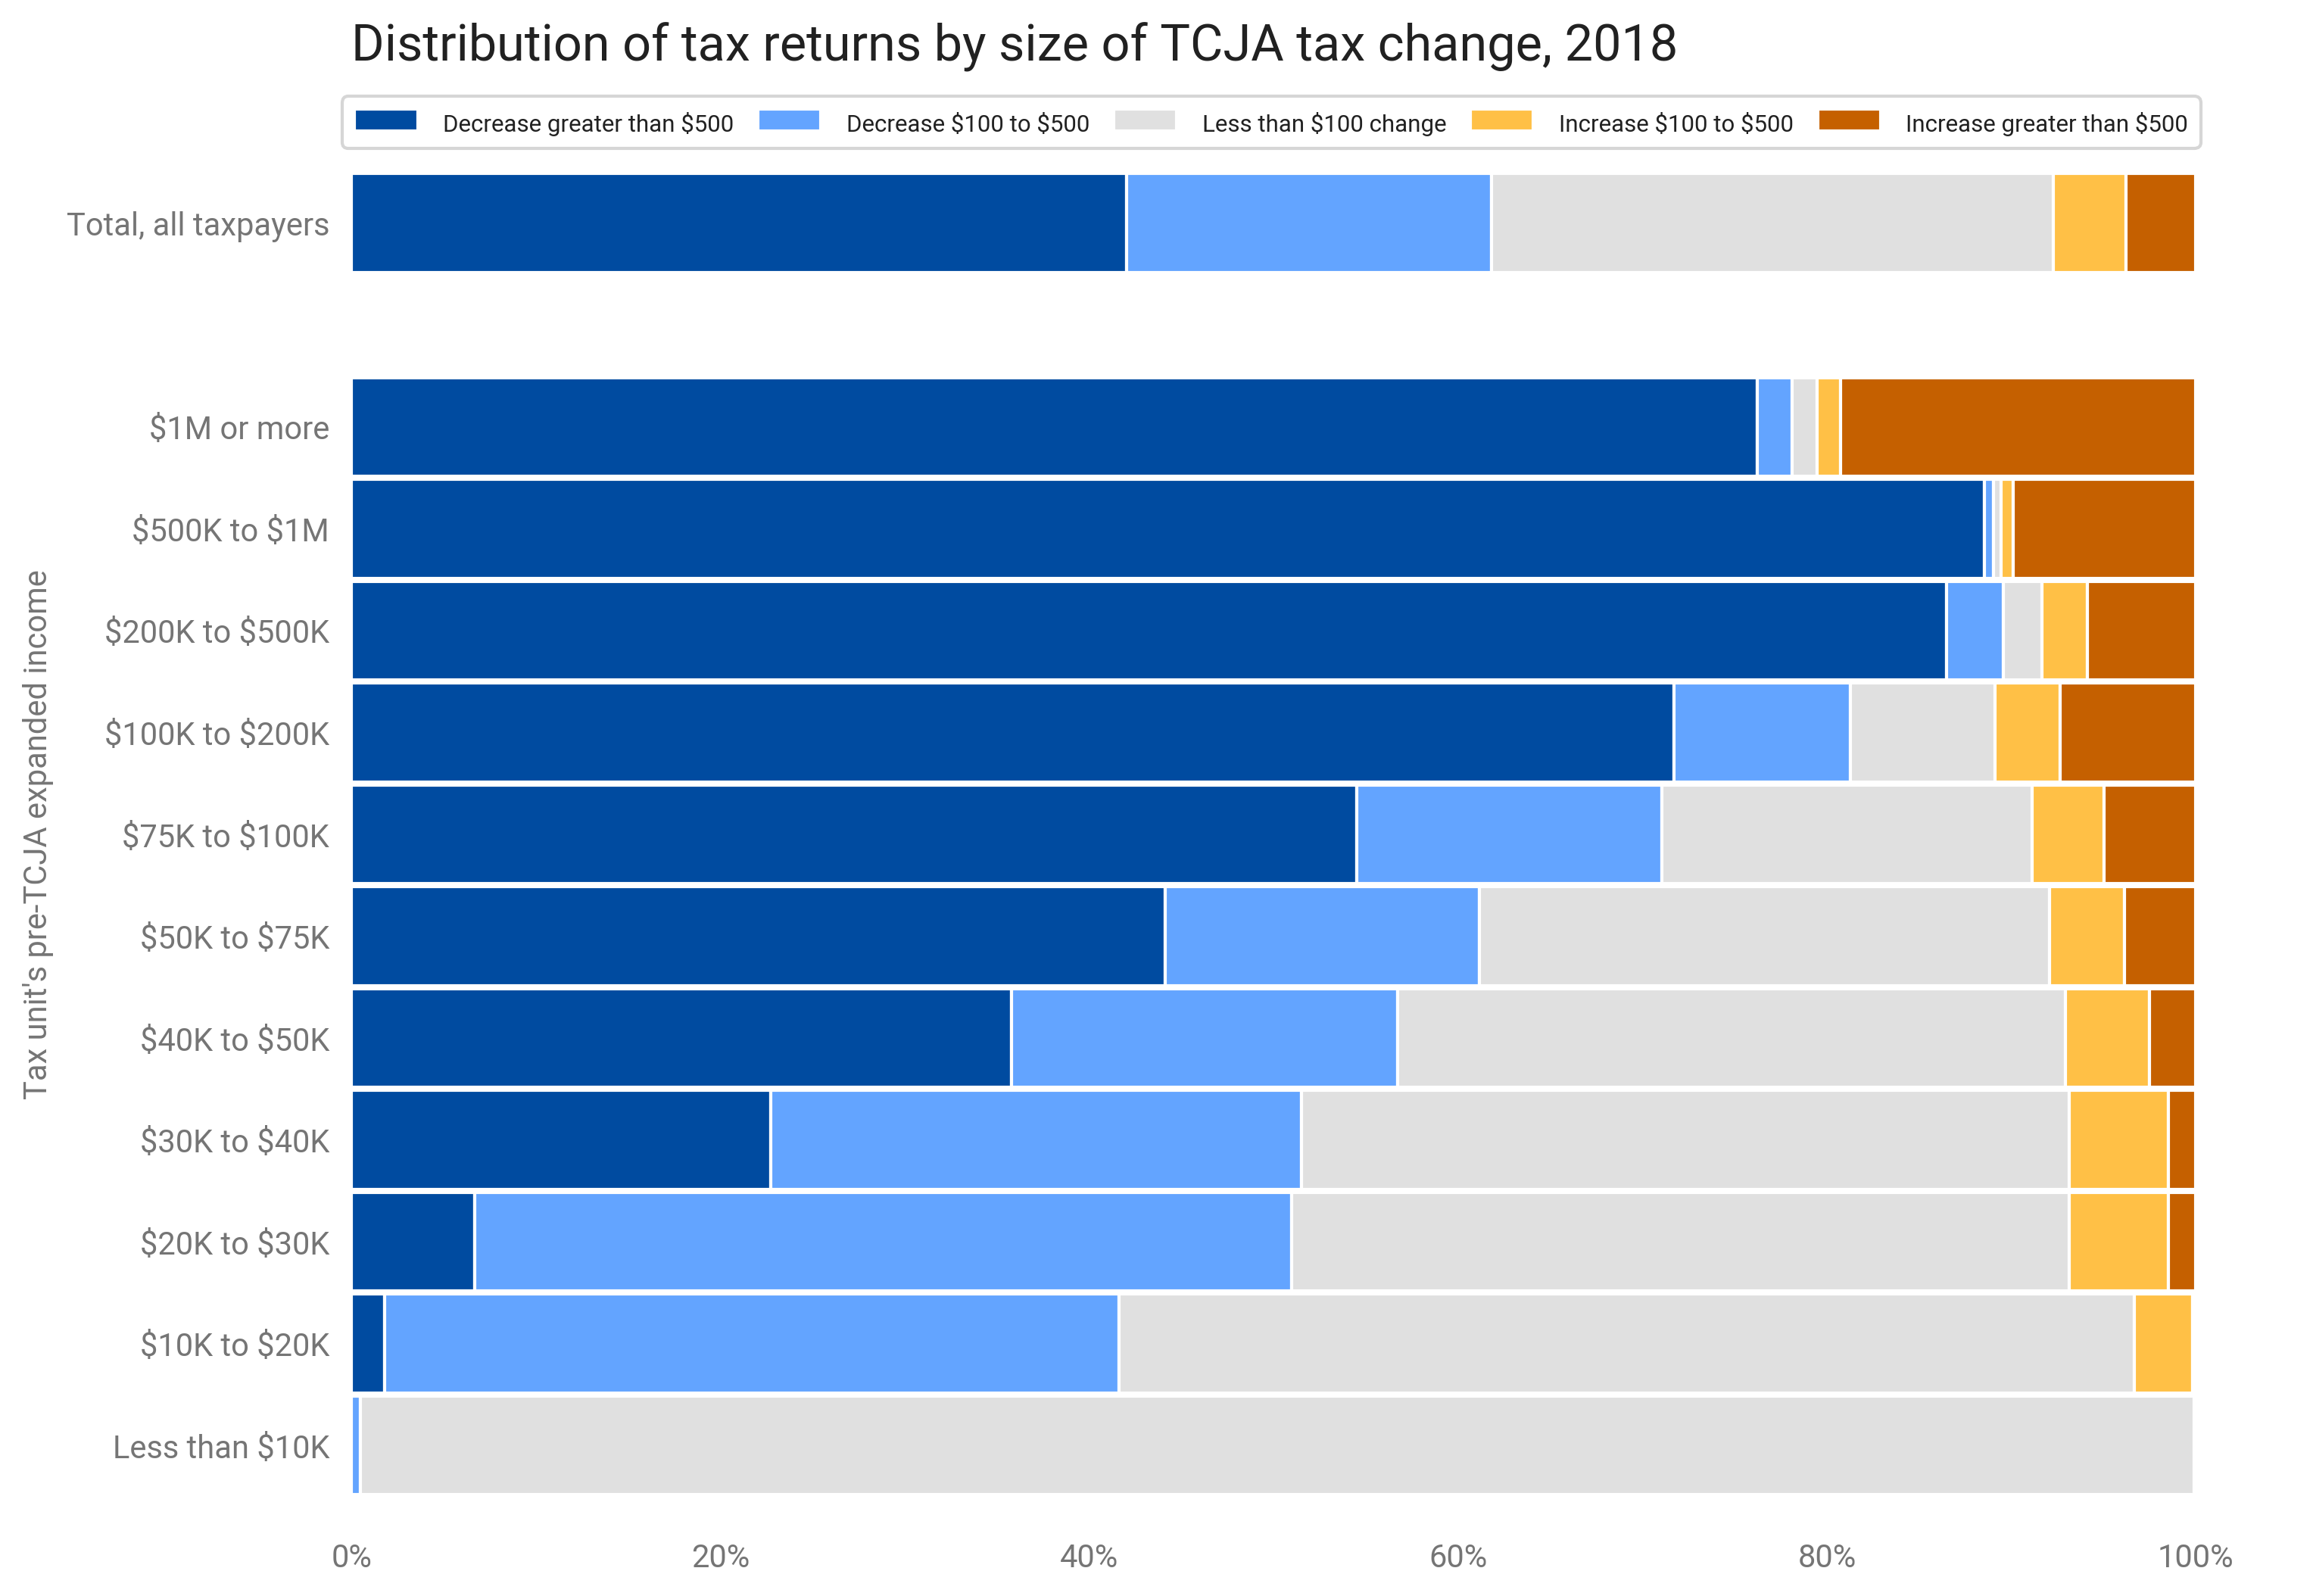

In [18]:
dist_plot('expi_base_bin', 'tax_chg_bin', 's006')

##### After-tax income bins

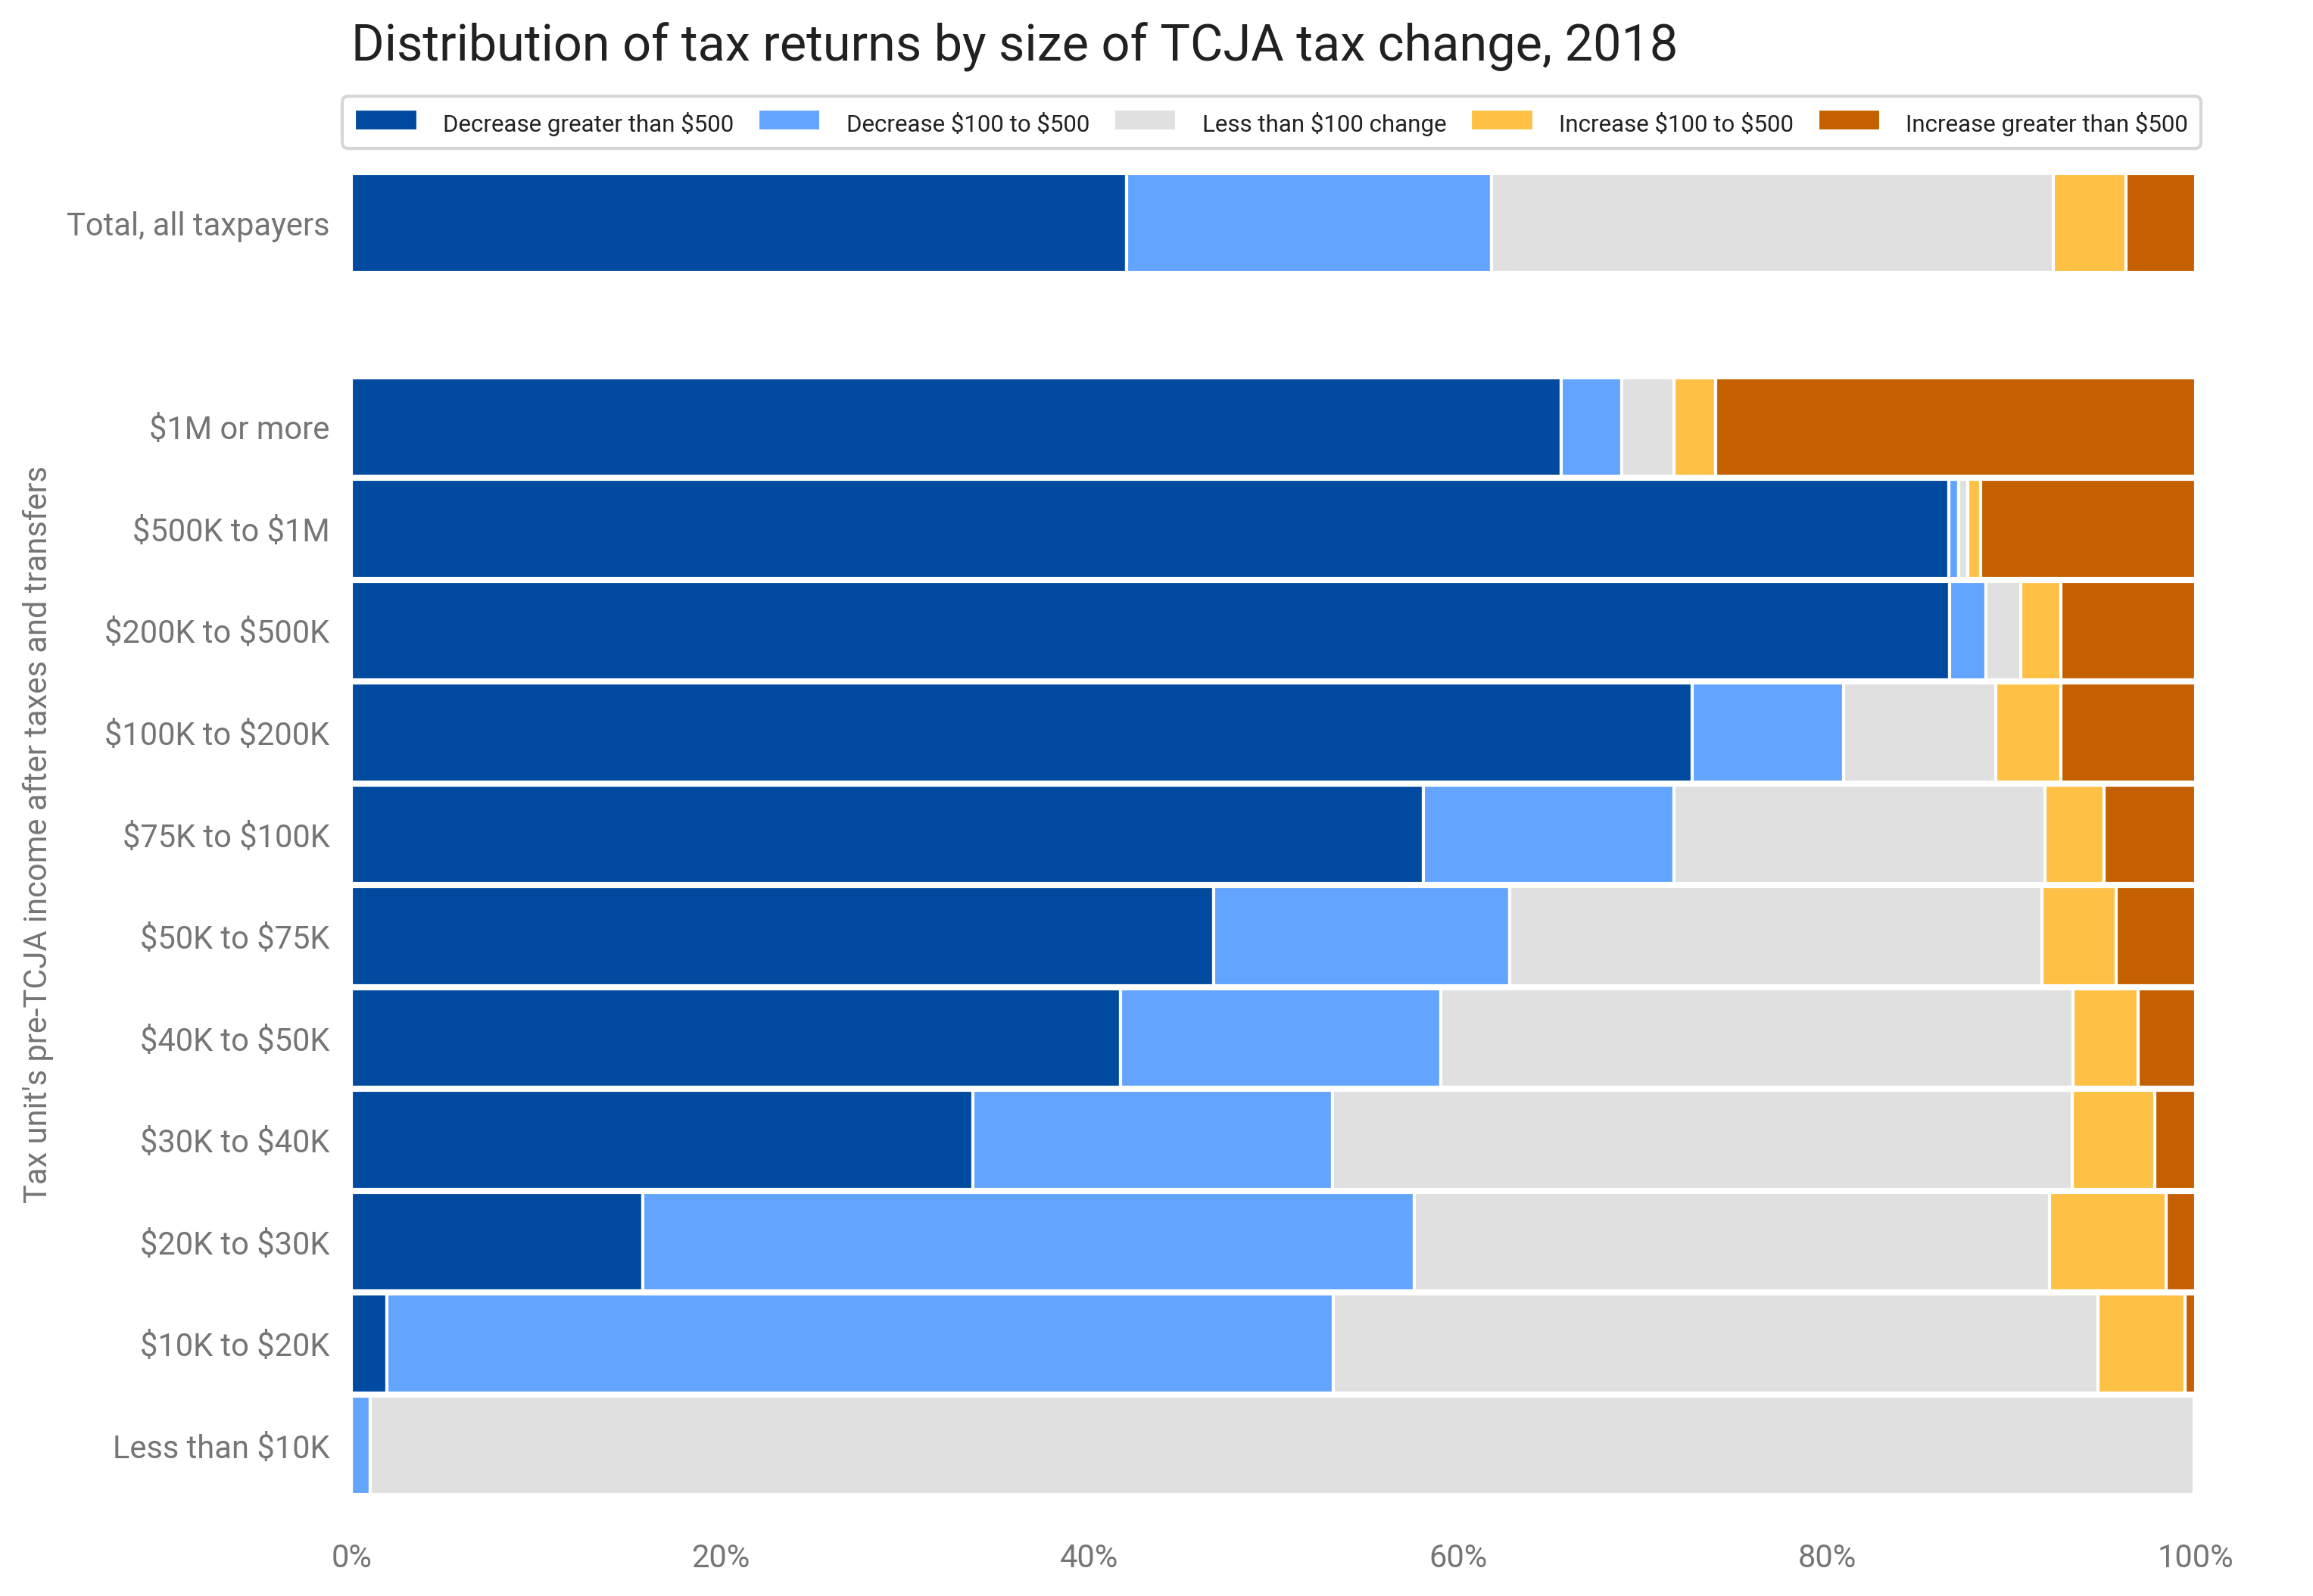

In [19]:
dist_plot('afti_base_bin', 'tax_chg_bin', 's006')

#### By % change to after-tax income

##### Expanded income bins

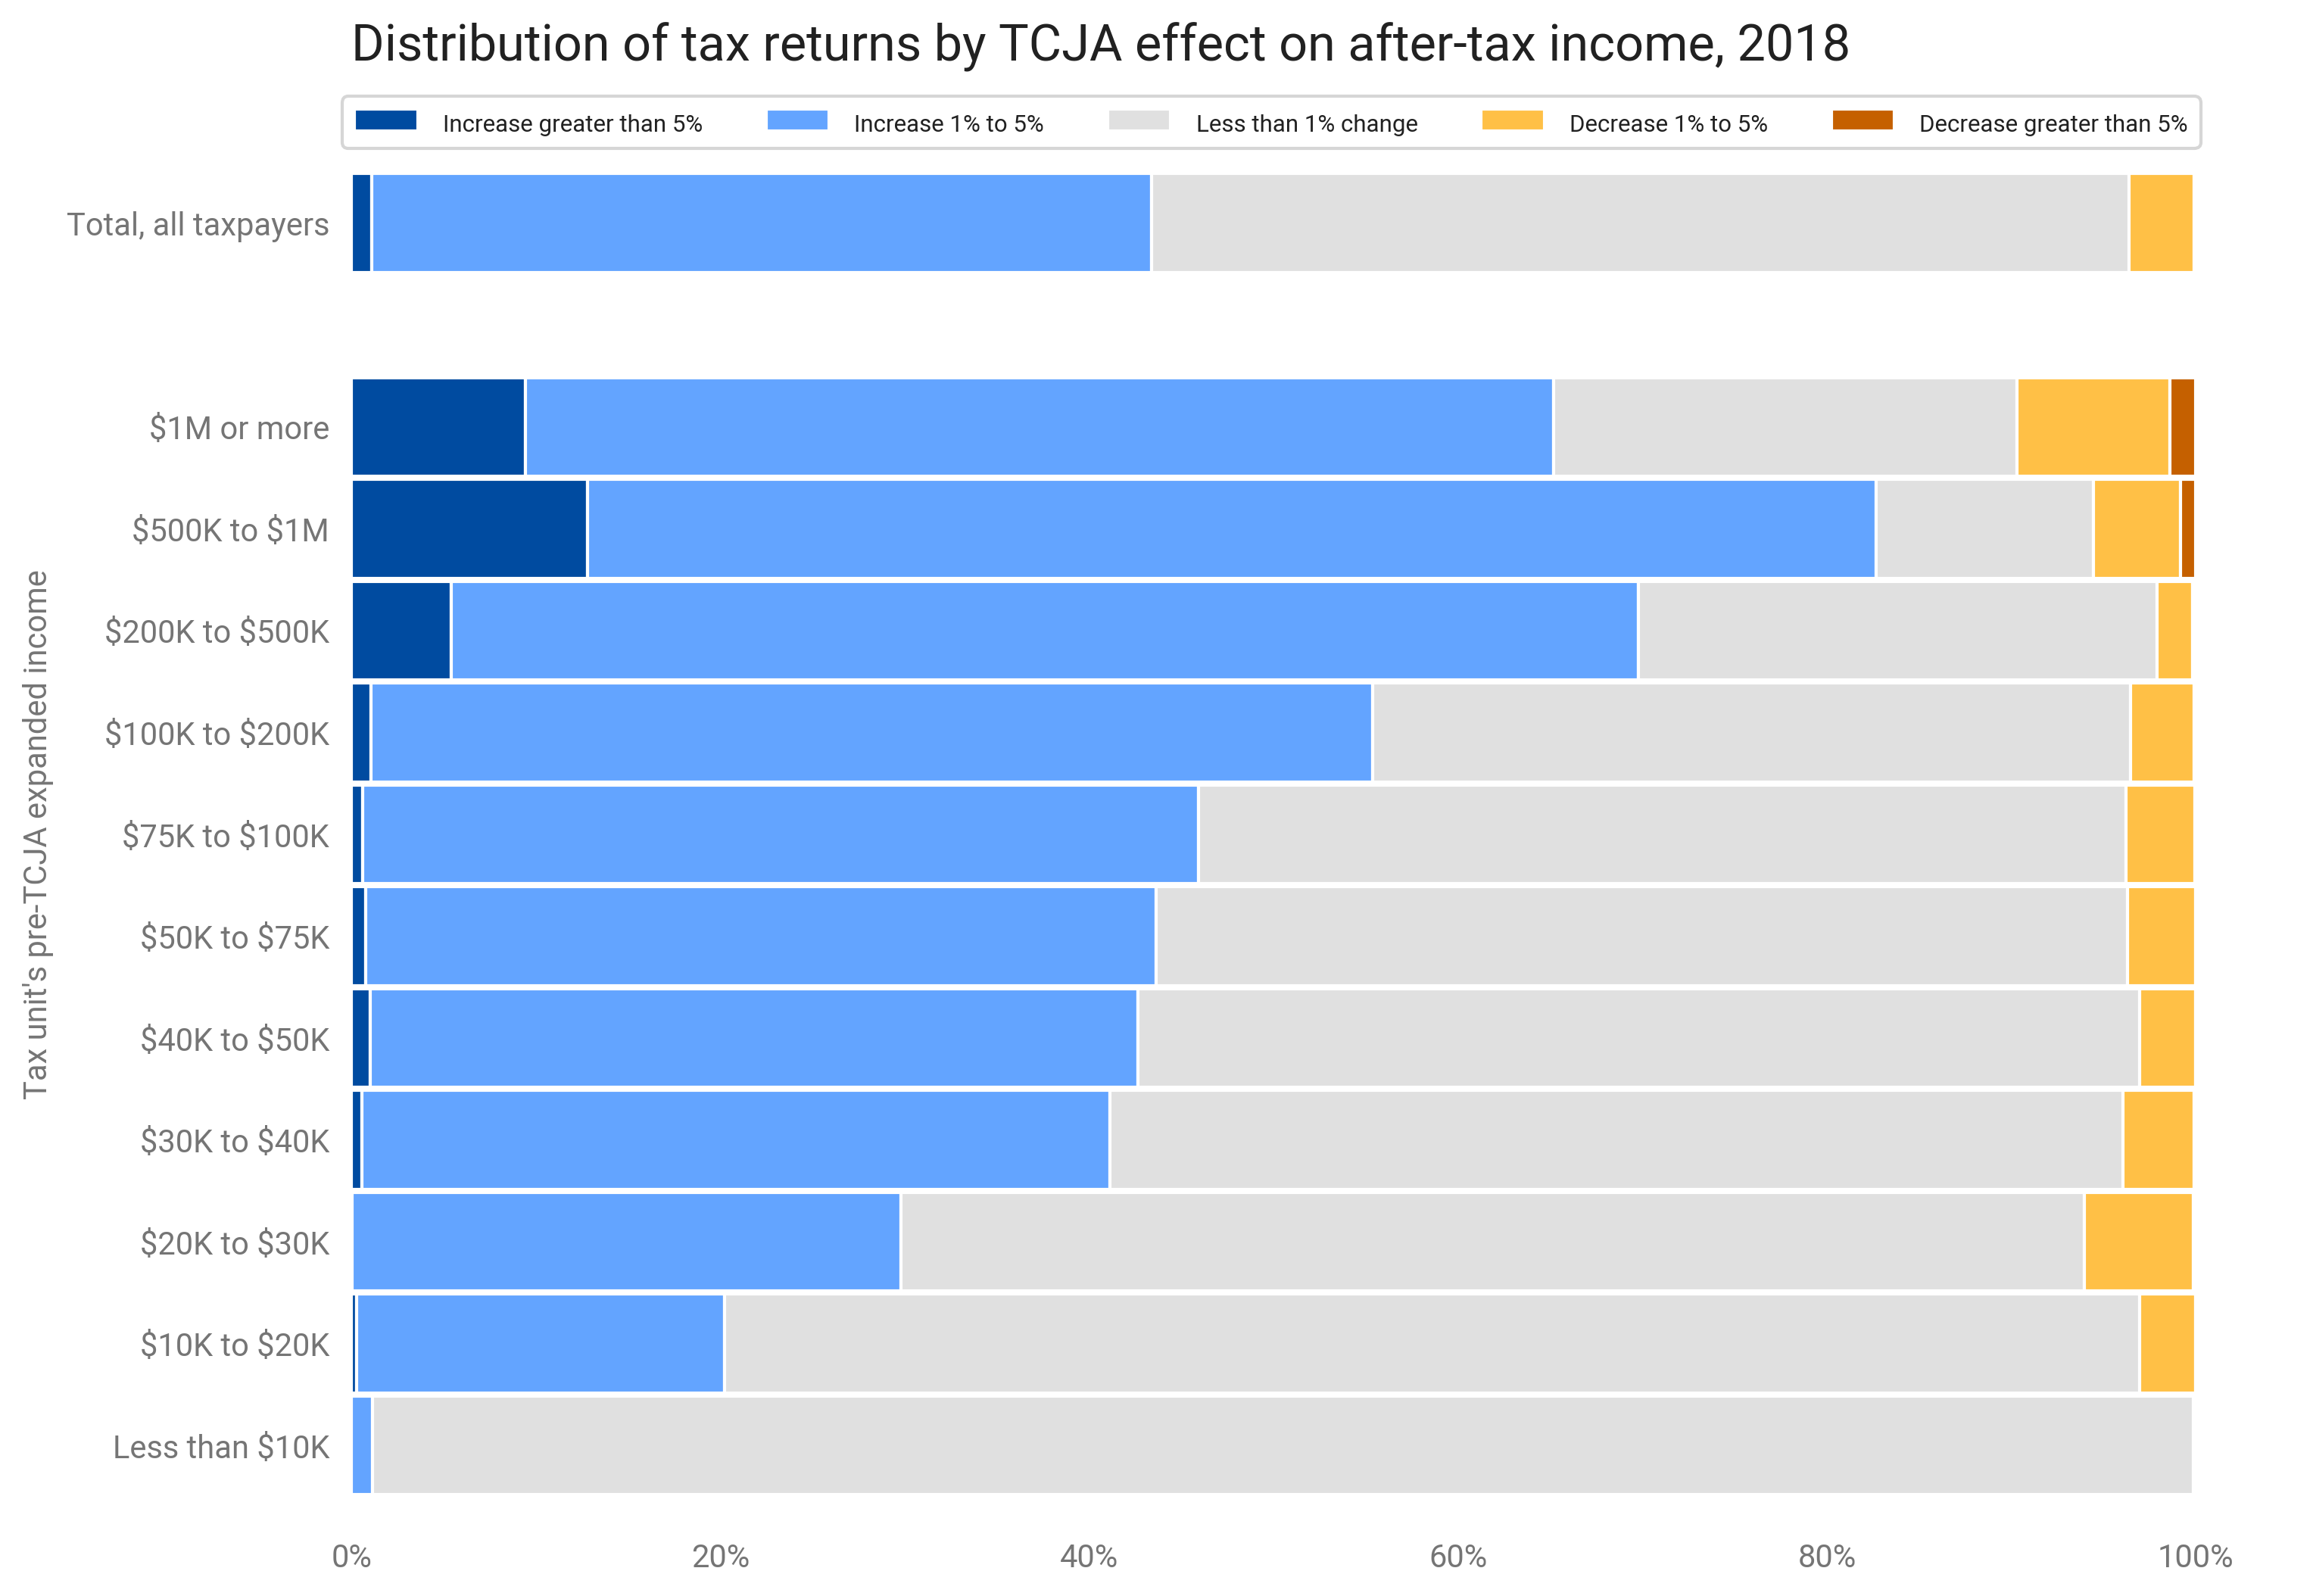

In [20]:
dist_plot('expi_base_bin', 'afti_pctchg_bin', 's006')

##### After-tax income bins

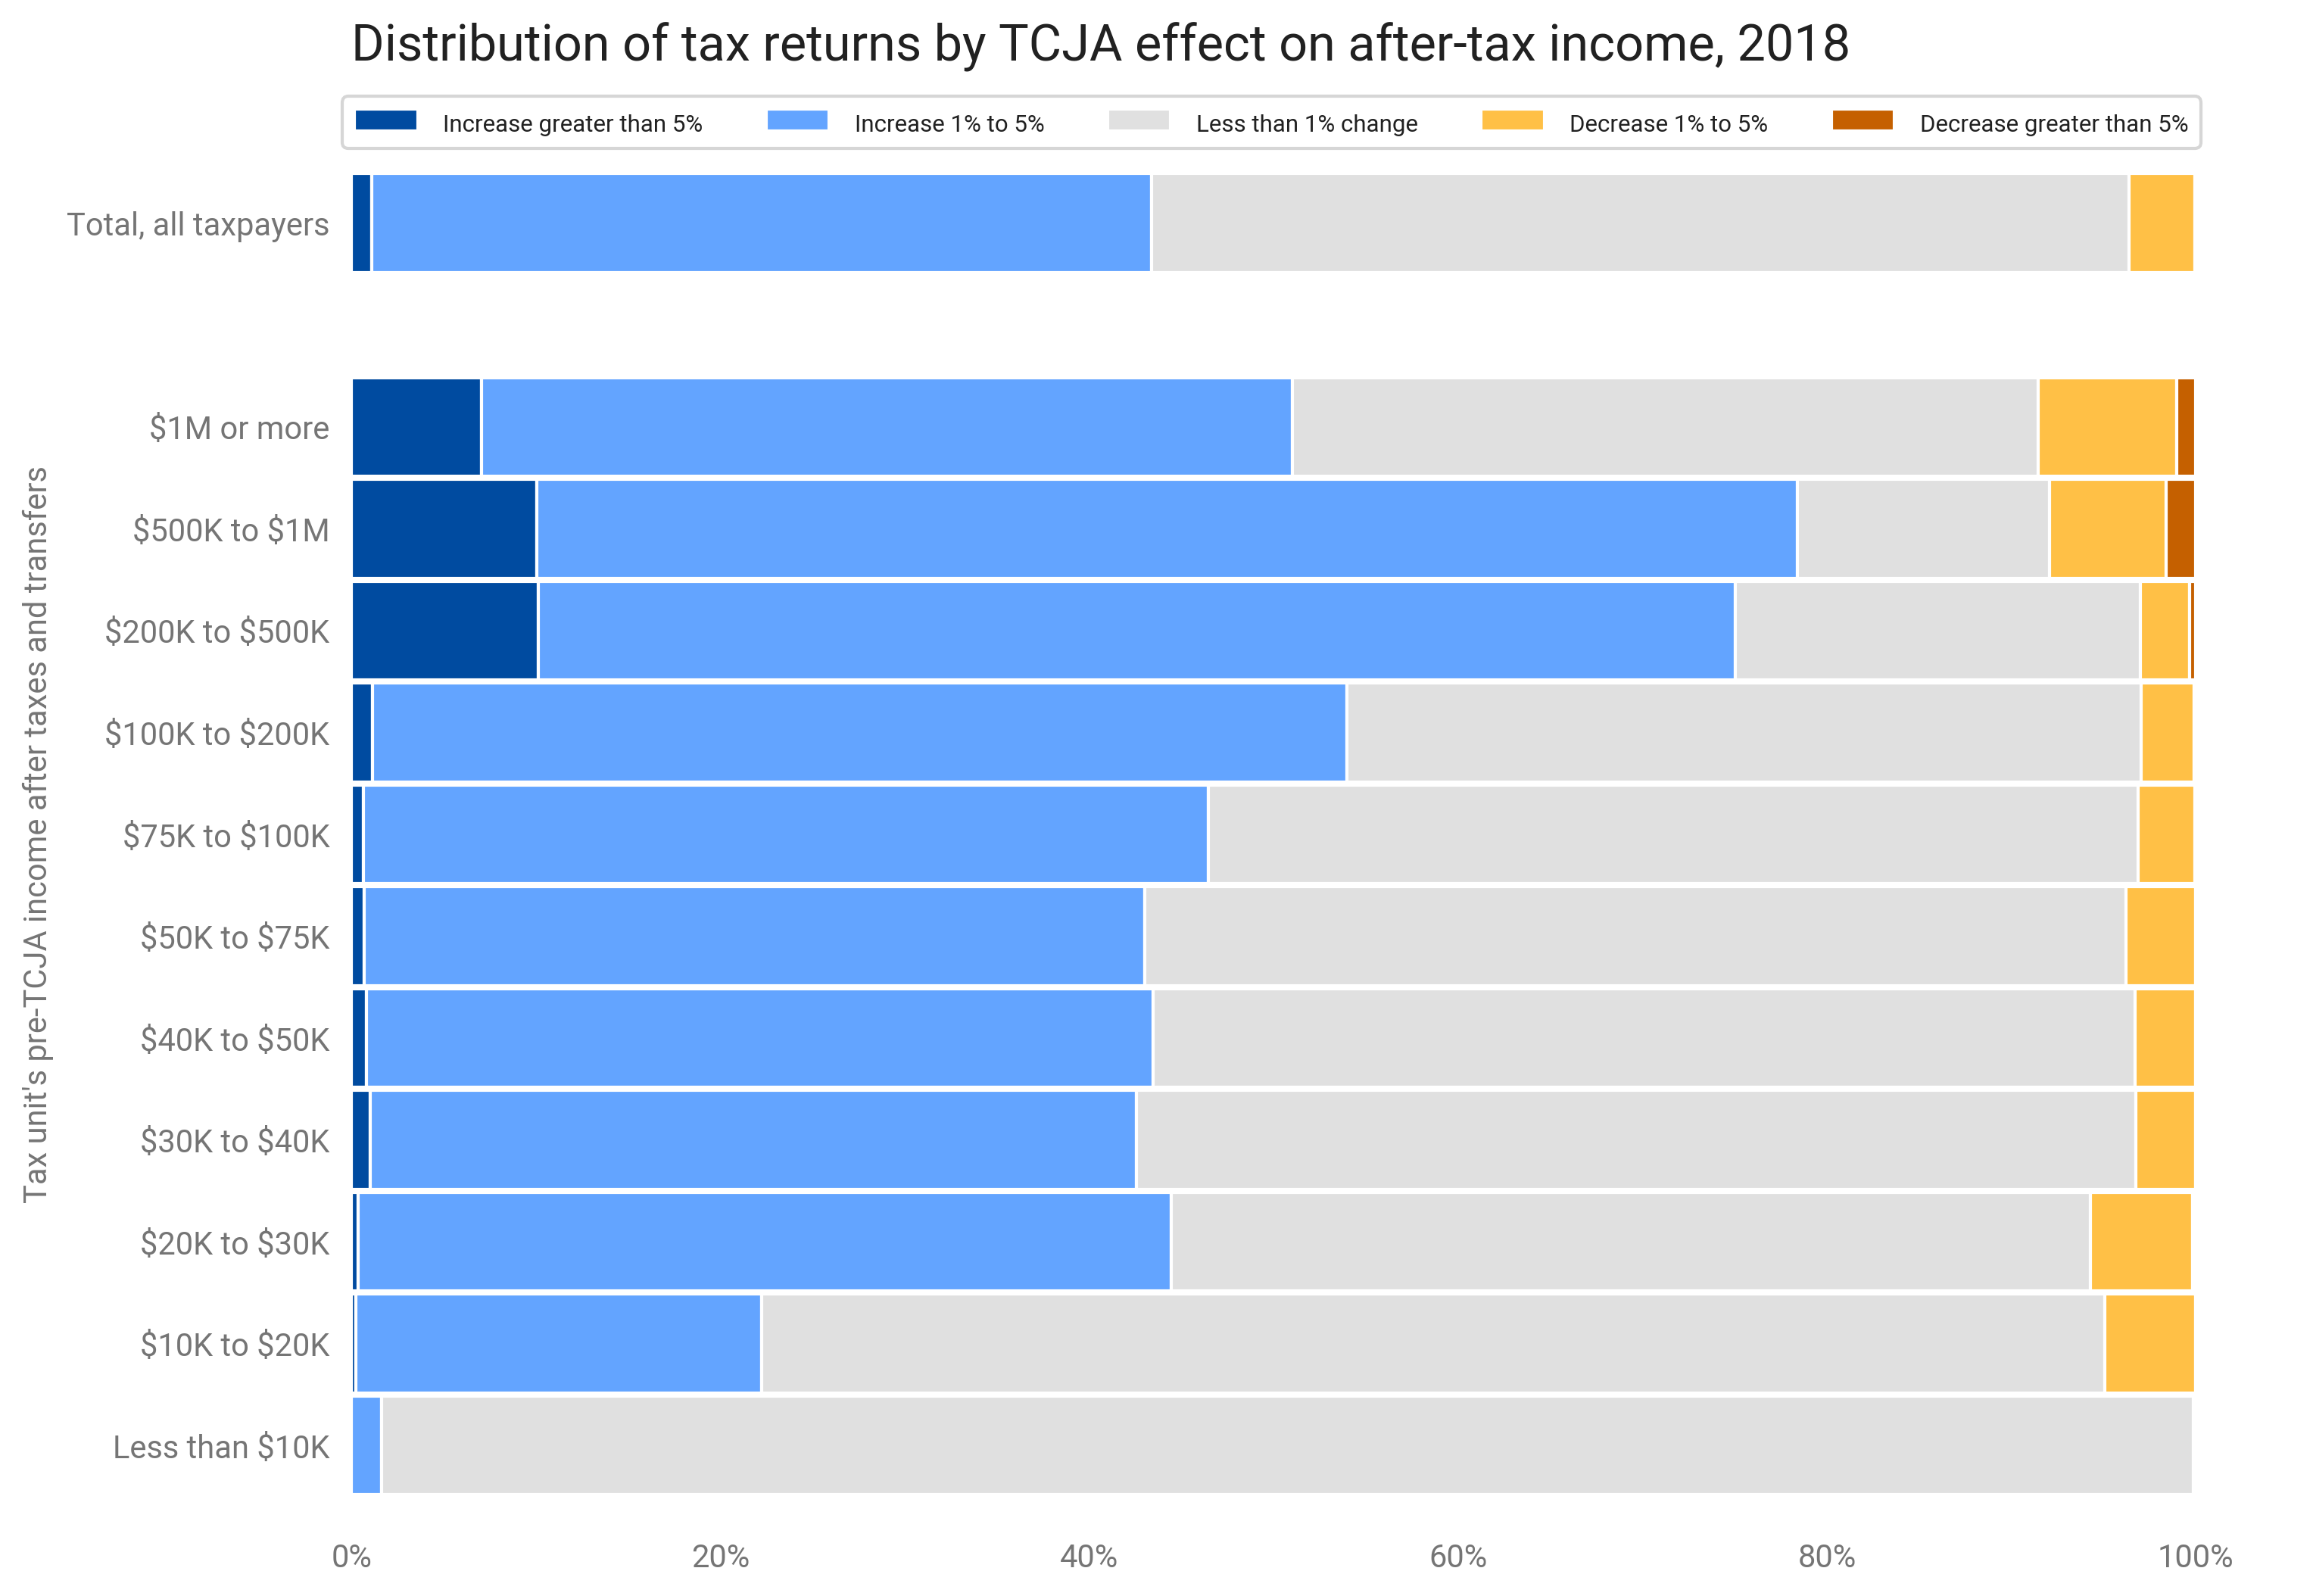

In [21]:
dist_plot('afti_base_bin', 'afti_pctchg_bin', 's006')

### Weighted by person

#### By absolute change

##### Expanded income bins

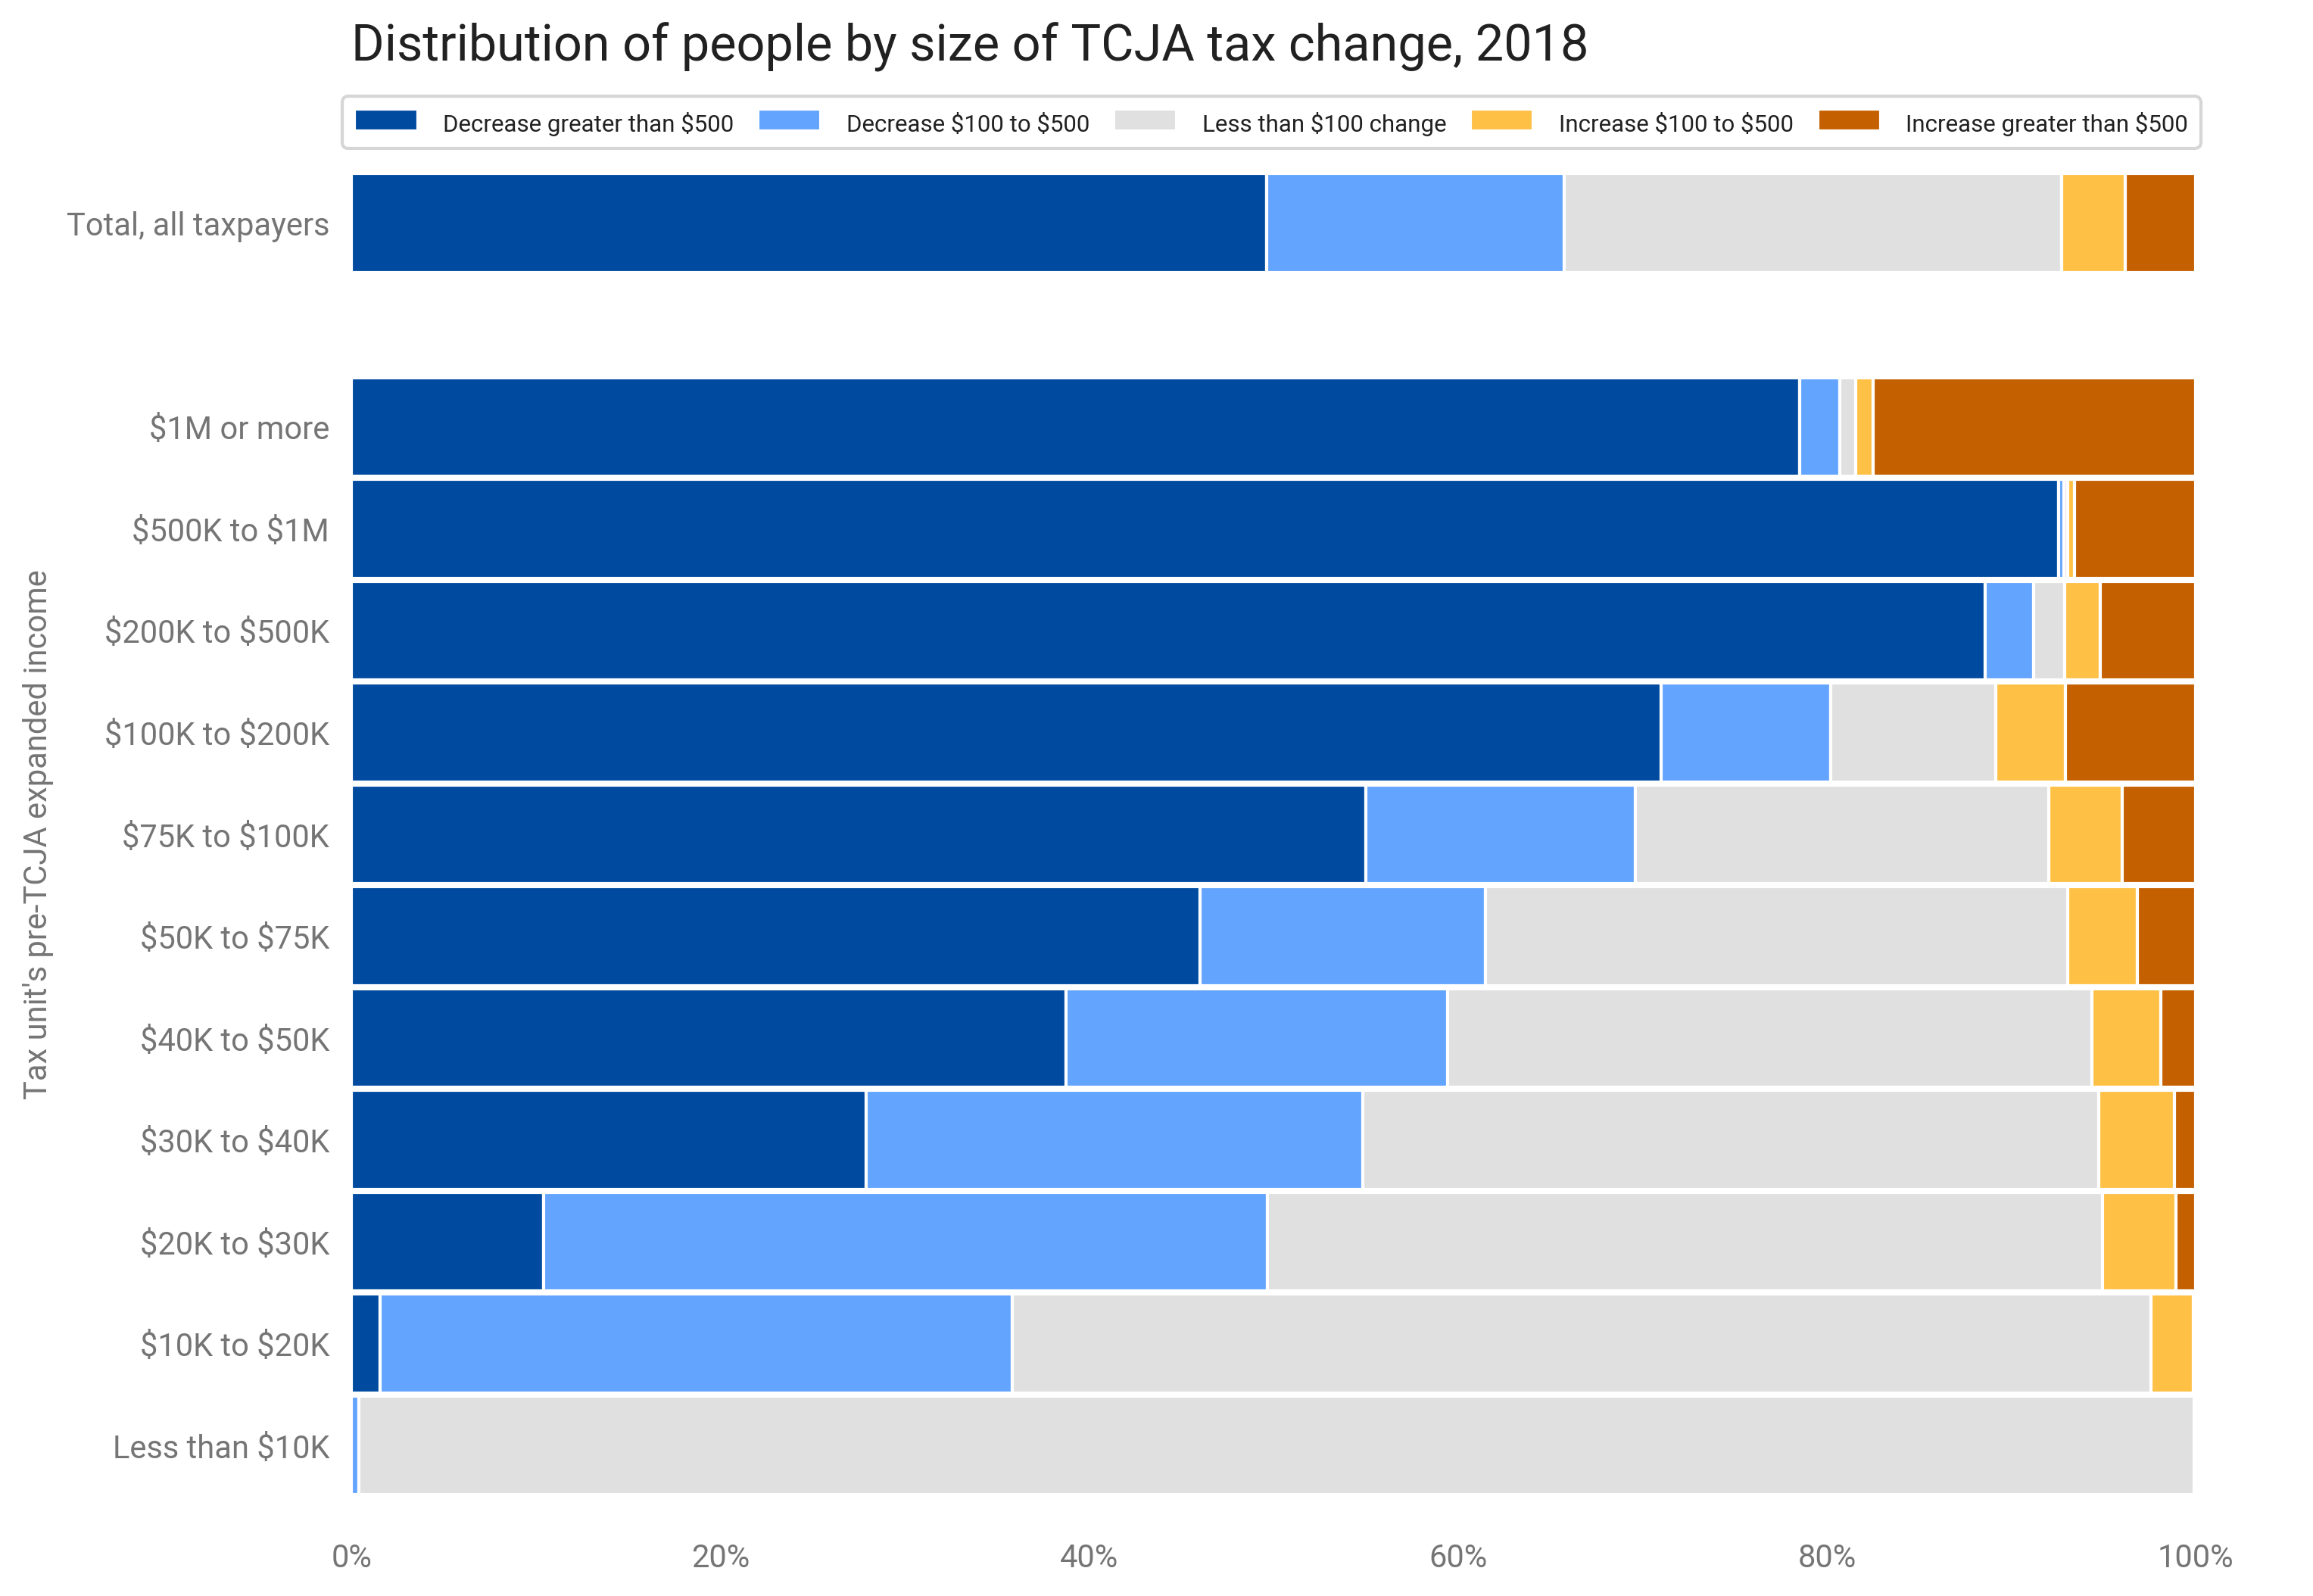

In [22]:
dist_plot('expi_base_bin', 'tax_chg_bin', 'XTOT_s006')

##### After-tax income bins

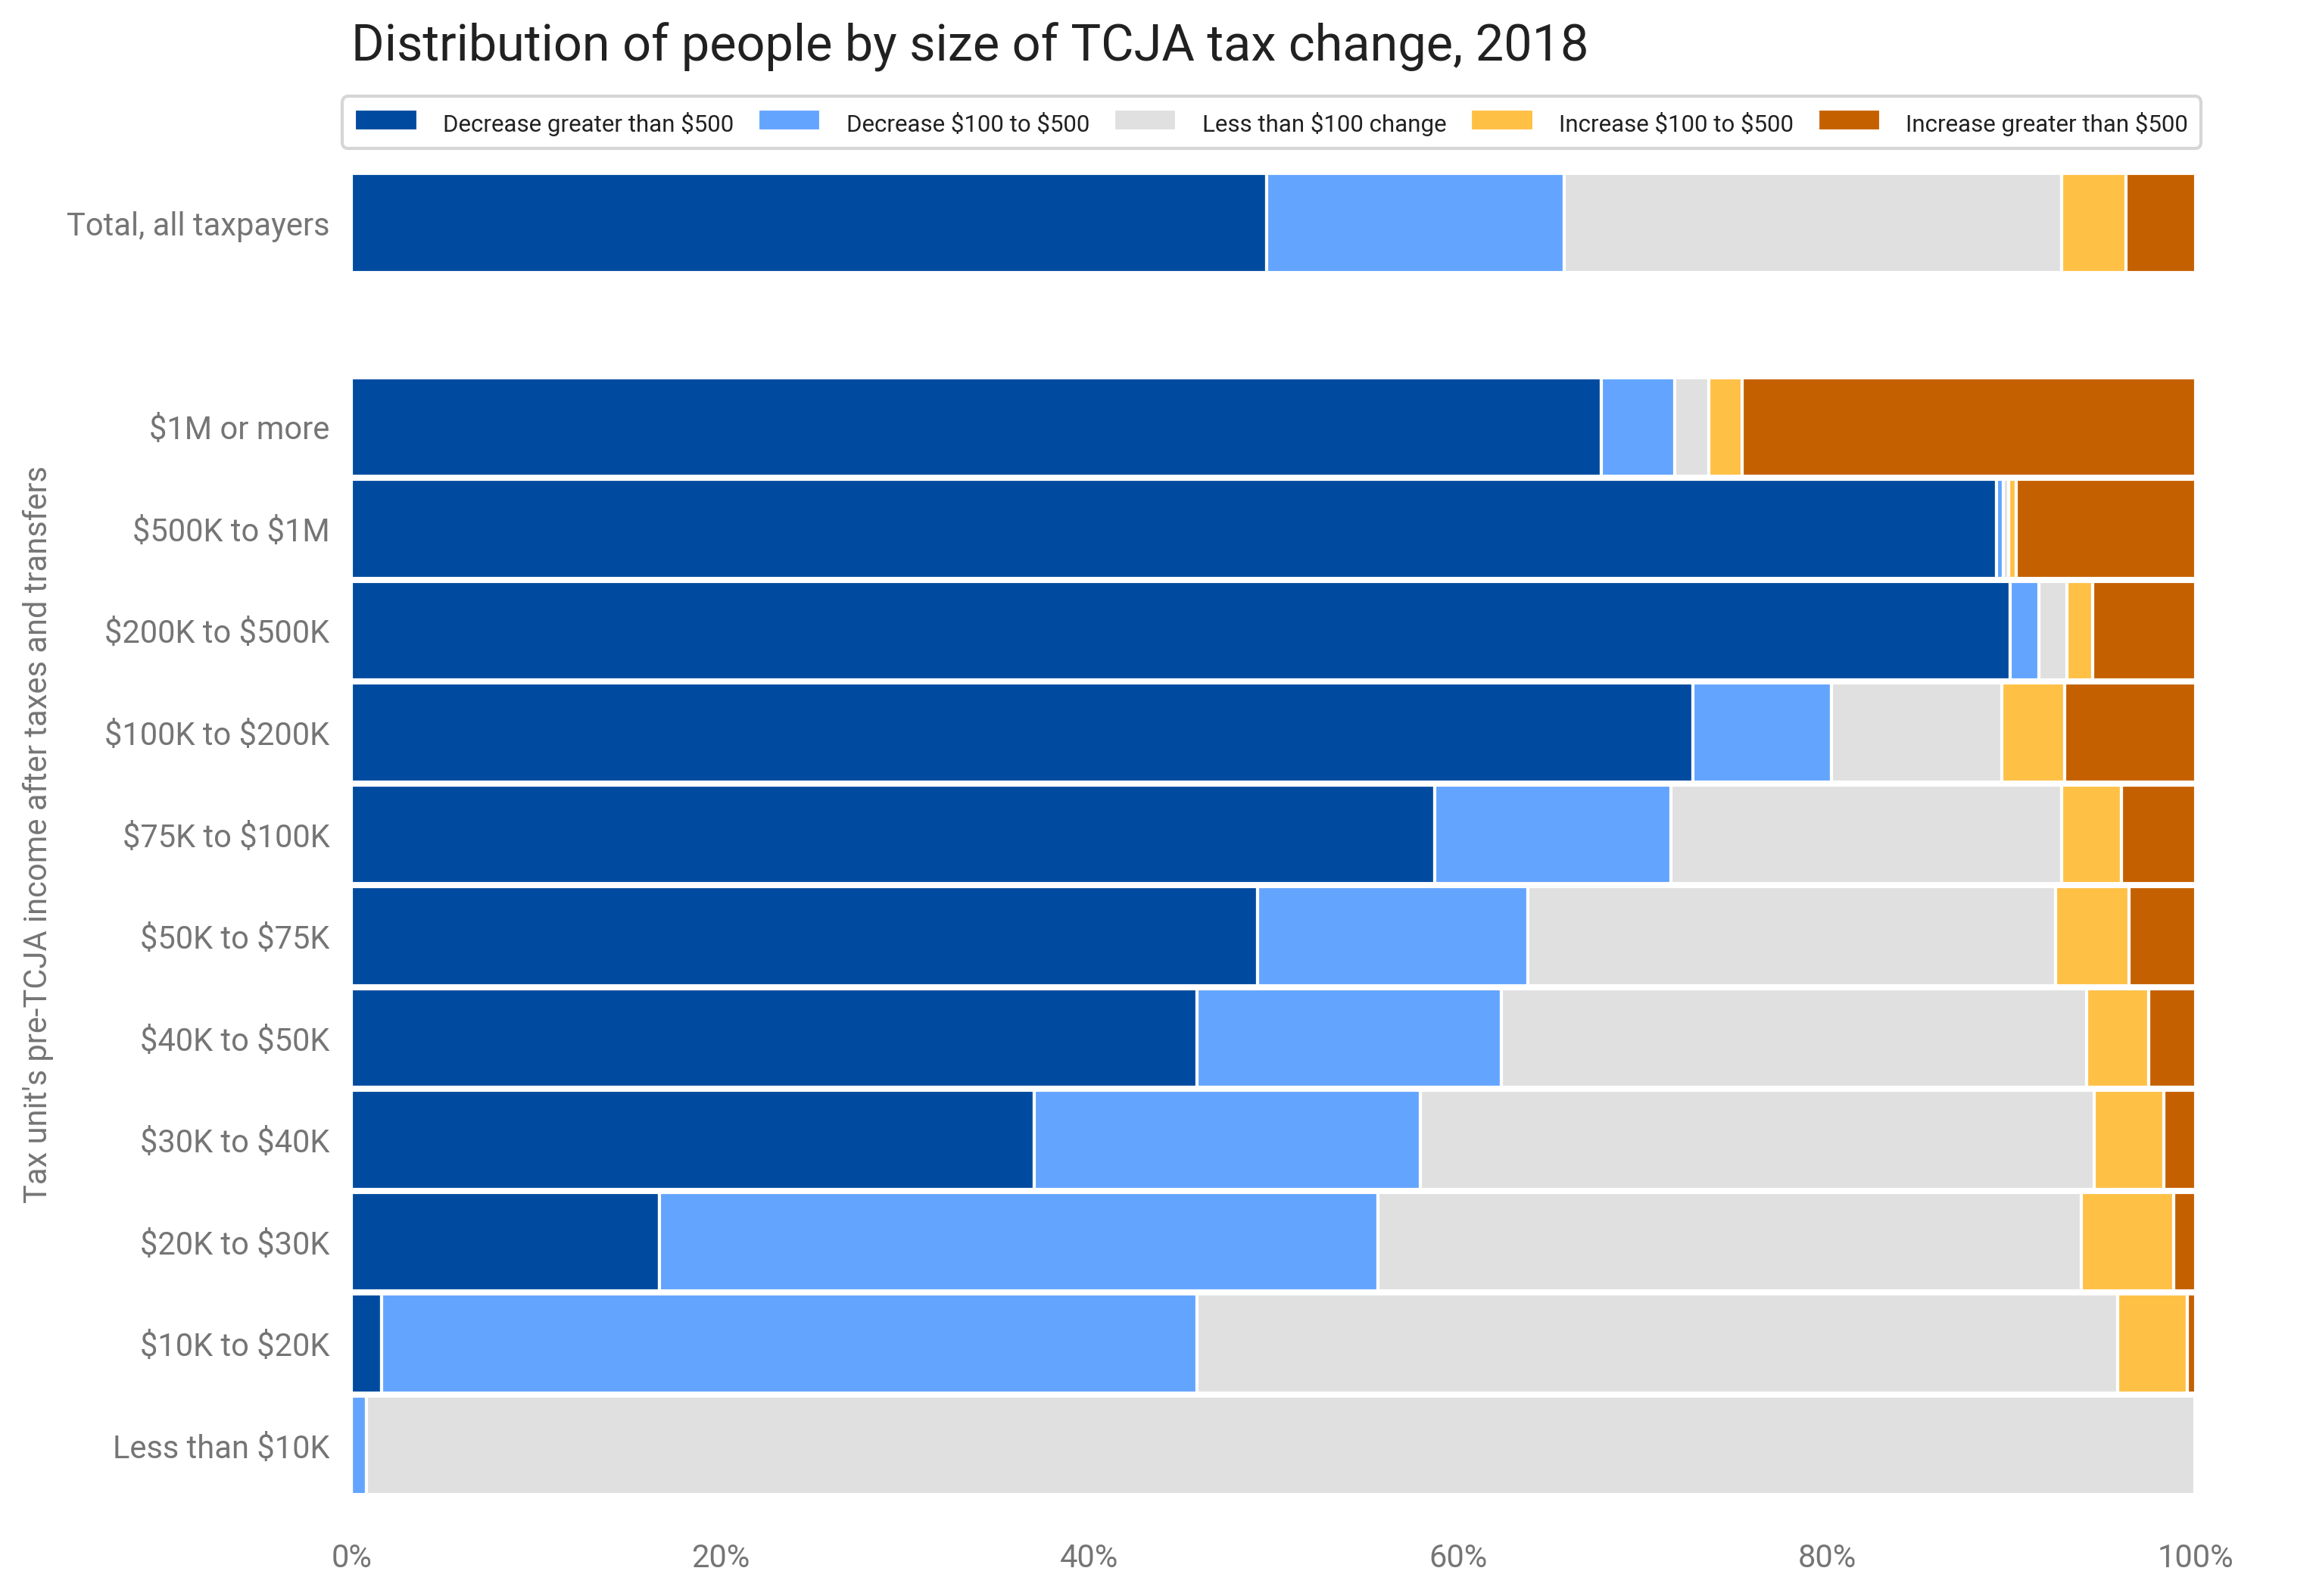

In [23]:
dist_plot('afti_base_bin', 'tax_chg_bin', 'XTOT_s006')

#### By % change to after-tax income

##### Expanded income bins

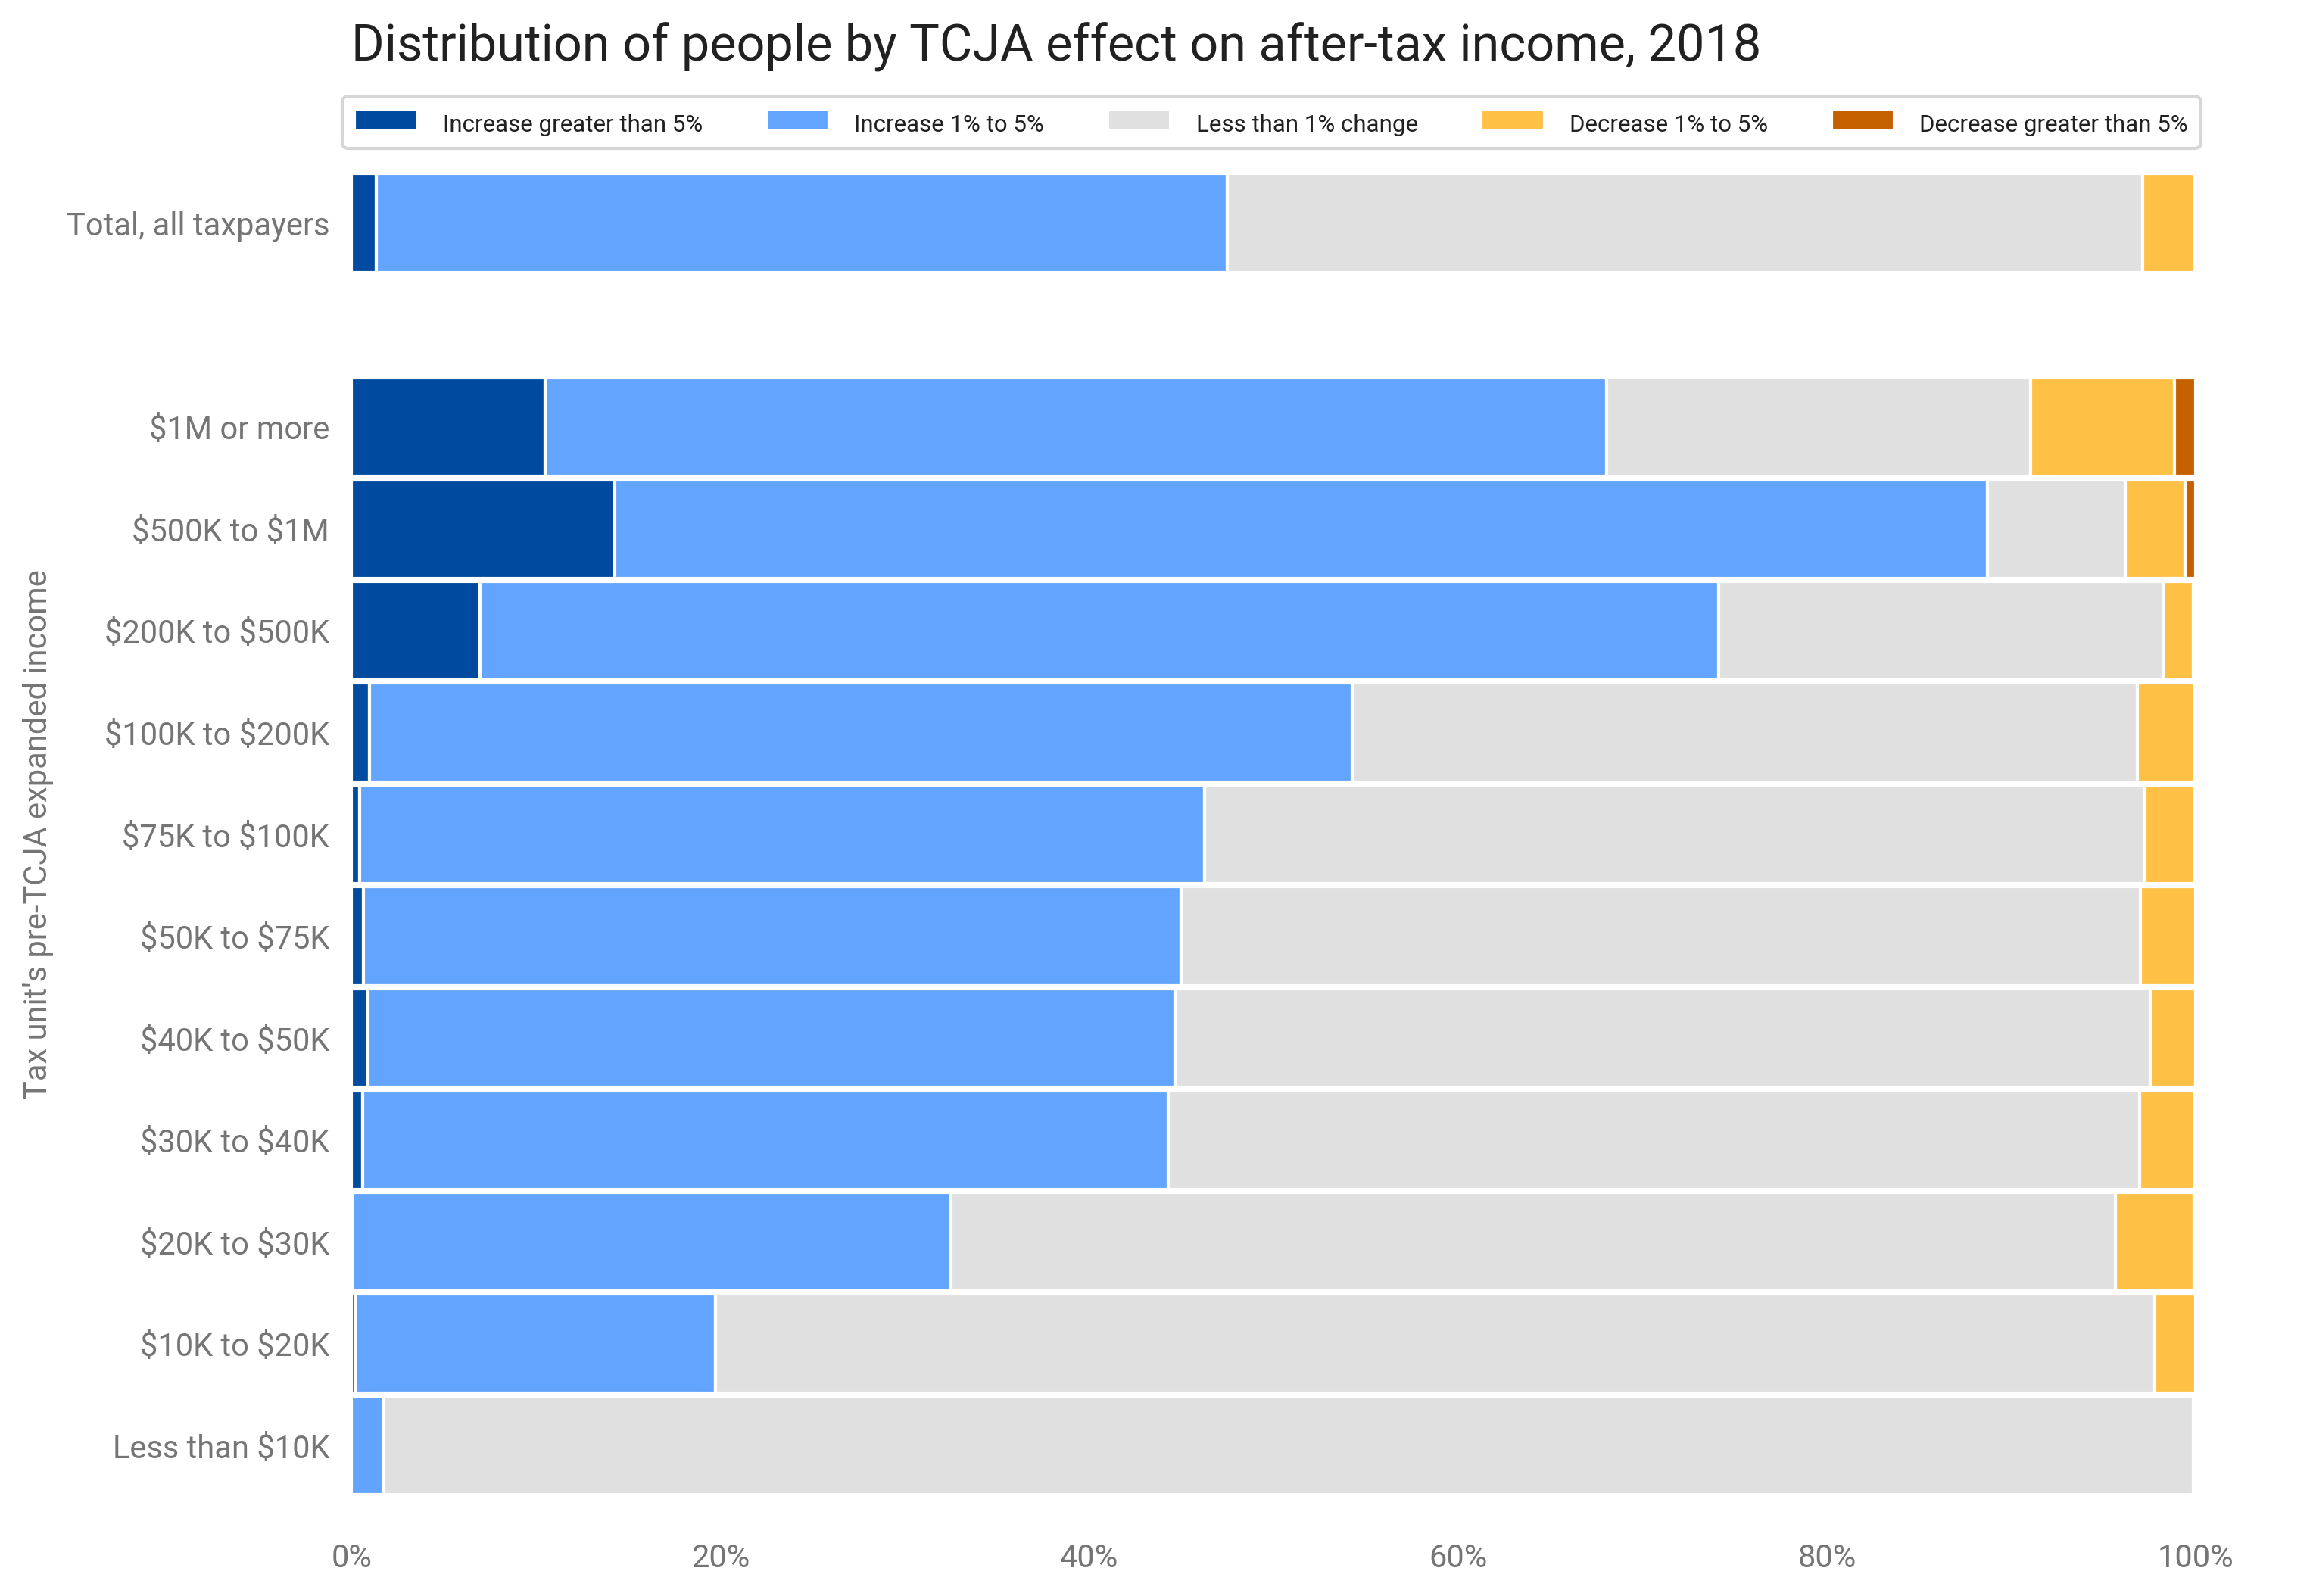

In [24]:
dist_plot('expi_base_bin', 'afti_pctchg_bin', 'XTOT_s006')

##### After-tax income bins

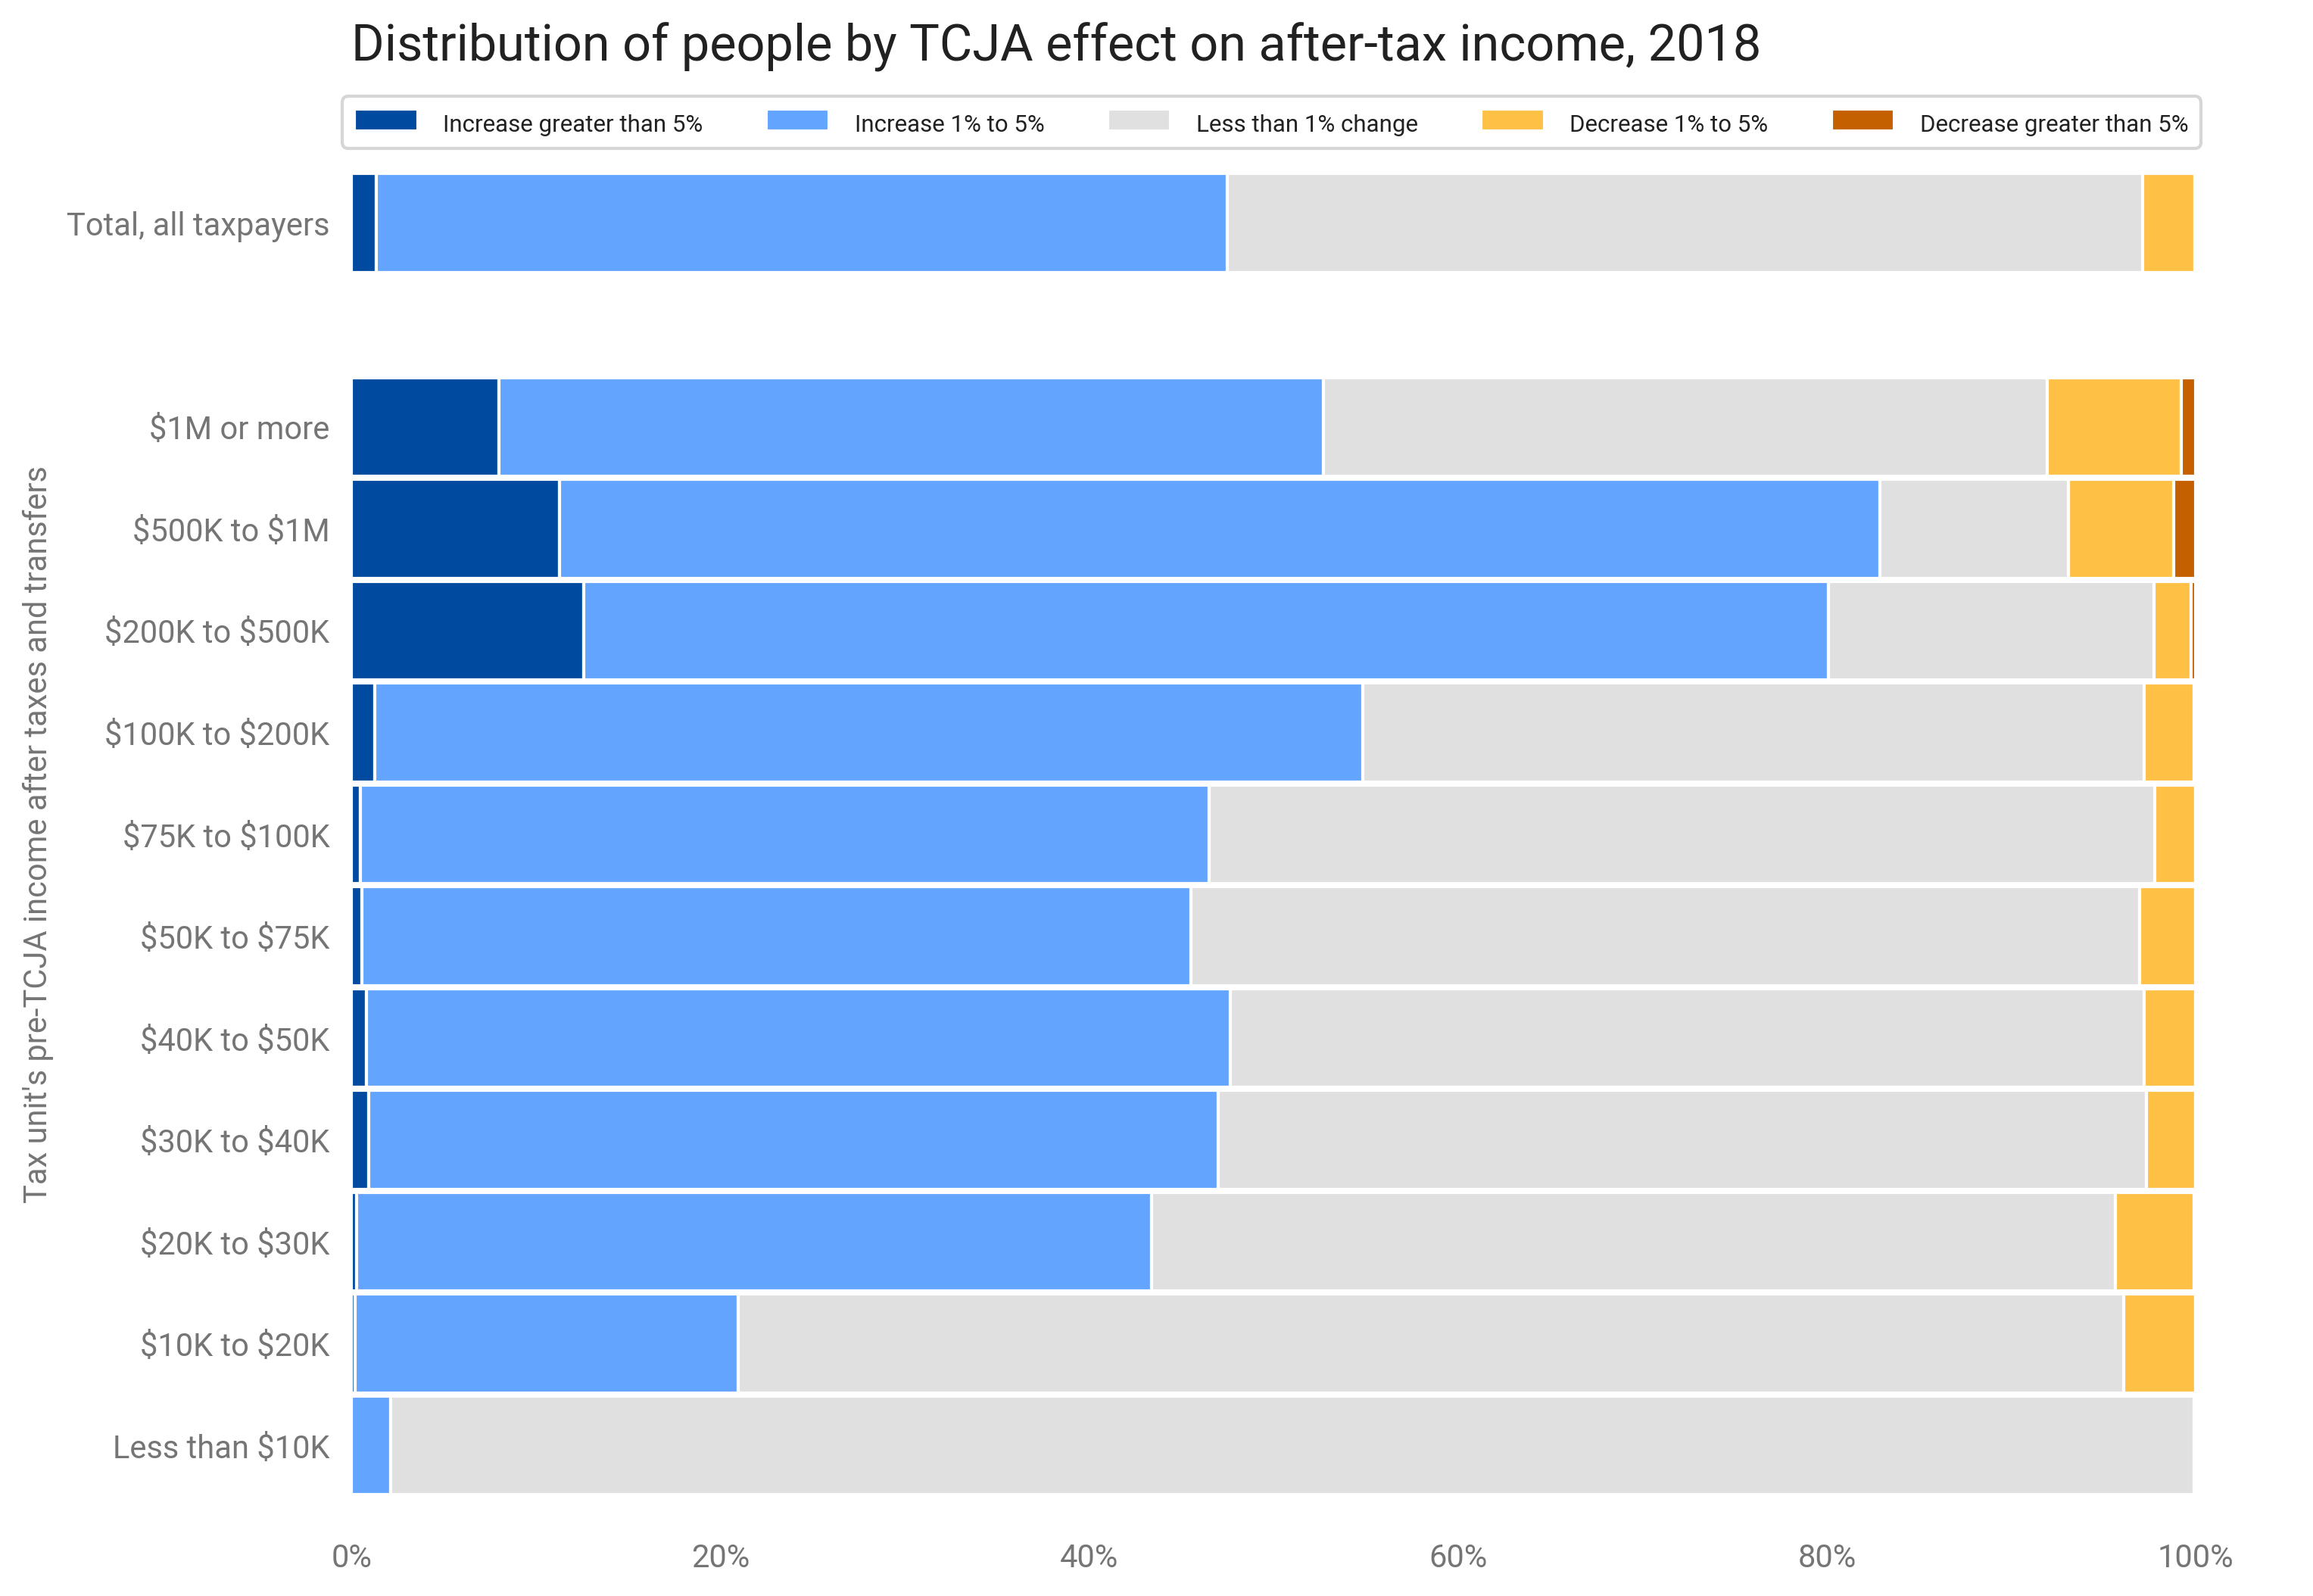

In [25]:
dist_plot('afti_base_bin', 'afti_pctchg_bin', 'XTOT_s006')